In [133]:
import pandas as pd
import numpy as np
import unidecode

pd.set_option('display.max_column',None)
pd.set_option('display.max_row',5000)

import os, json, csv, glob

In [134]:
records = pd.read_csv("/Users/mk2/Documents - Gabriel’s MacBook Pro/dadaset/records.csv")

### Preprocess

In [135]:
records = records.drop(columns= ["Unnamed: 0"])
records.infer_objects()
records["date"] = pd.to_datetime(records["date"],format='%d/%m/%y')

In [136]:
records = records.sort_values(by=["date","race_index","result"], ascending=False)
records.reset_index(inplace=True, drop=True)

In [137]:
records.columns

Index(['race_id', 'race_index', 'result', 'date', 'venue', 'dist',
       'turf_quality', 'race_class', 'draw', 'rating', 'trainer', 'jockey',
       'lbw', 'win_odds', 'actual_weight', 'running_pos1', 'running_pos2',
       'running_pos3', 'running_pos4', 'running_pos5', 'finish_time',
       'declared_weight', 'gear', 'id', 'name', 'details', 'country_of_origin',
       'age', 'colour', 'sex', 'import_type', 'season_stakes', 'total_stakes',
       'win_counts', 'second_count', 'third_count', 'horse_exp',
       'no_starts_past_10', 'current_stable_loc', 'arrival_date', 'trainer.1',
       'owner', 'current_rating', 'start_ofseason_rating', 'sire', 'dam',
       'dams_sire', 'same_sire'],
      dtype='object')

In [138]:
records.drop(columns=['season_stakes', 'total_stakes',
       'win_counts', 'second_count', 'third_count', 'horse_exp',
       'no_starts_past_10', 'current_stable_loc', 'arrival_date','current_rating', 'start_ofseason_rating'],inplace=True)

### Variables

#### Age

In [139]:
records.loc[:,('rest_time')] = (records.groupby('name')["date"].diff(periods=-1).dt.days.fillna(0))

records.loc[:,('cumul_rest_time')] = records.groupby('name')['rest_time'].cumsum().fillna(0)

records.loc[:,('real_age')] = (records['age'] - records['cumul_rest_time']/365).round()

In [140]:
records["real_age"].corr(records["result"])

-0.0018761449865074755

#### General

In [141]:
records.loc[:,('speed')] = (records['dist'] / records['finish_time']).round(2)

records.loc[:,('horse_exp')] = records.groupby(['name']).cumcount(ascending=False)

records.loc[:,("distance_exp")] = records.groupby(["name","dist"]).cumcount(ascending=False)

records.loc[:,("horse_jockey_exp")] = records.groupby(["name","jockey"]).cumcount(ascending=False)

#### Prev

In [142]:
records.loc[:,('prev_speed')] = records.groupby('name')[('speed')].shift(periods=-1)

records.loc[:,('prev_result')] = records.groupby('name')[('result')].shift(periods=-1)

records["prev_actual_weight"] = records.groupby('name')['actual_weight'].shift(periods=-1)

records["prev_declared_weight"] = records.groupby(['name'])['declared_weight'].shift(periods=-1)

records.loc[:,('prev_time')] = records.groupby(["name","dist"])[('finish_time')].shift(periods=-1)

records.loc[:,('prev_running_pos4')] = records.groupby('name')[('running_pos4')].shift(periods=-1)

records.loc[:,('prev_running_pos3')] = records.groupby('name')[('running_pos3')].shift(periods=-1)

records.loc[:,('prev_running_pos2')] = records.groupby('name')[('running_pos2')].shift(periods=-1)

records.loc[:,('prev_running_pos1')] = records.groupby('name')[('running_pos1')].shift(periods=-1)

#### Change

In [143]:
records["actual_wt_change"] = records['actual_weight'] - records['prev_actual_weight']

records["declared_wt_change"] = records['declared_weight'] - records['prev_declared_weight']

records["prev_speed_change"] = records['prev_speed'] - records['prev_speed'].shift(periods=-1)

#### Ranks

In [144]:
records.loc[:,("odds_rank")] = records.loc[:,("win_odds")].rank(pct=True, ascending=False)

records.loc[:,("real_age_ranl")] = records.groupby(["race_index","date"])["real_age"].rank(pct=True, ascending=False)

records.loc[:,("cond_odds_rank")] = records.groupby(["race_index","date"])["win_odds"].rank(pct=True, ascending=False)

records.loc[:,("prev_speed_rank")] = records.groupby(["race_index","date"])["prev_speed"].rank(pct=True, ascending=True)

records.loc[:,("distance_exp_rank")] = records.groupby(["race_index","date"])["distance_exp"].rank(pct=True, ascending=True)

records.loc[:,("actual_weight_rank")] = records.groupby(["race_index","date"])["actual_weight"].rank(pct=True, ascending=True)

records.loc[:,("declared_weight_rank")] = records.groupby(["race_index","date"])["declared_weight"].rank(pct=True, ascending=True)

records.loc[:,("actual_wt_change_rank")] = records.groupby(["race_index","date"])["actual_wt_change"].rank(pct=True, ascending=True)

records.loc[:,('prev_running_pos4_rank')] = records.groupby(["race_index","date"])["prev_running_pos4"].rank(pct=True, ascending=True)

records.loc[:,('prev_running_pos3_rank')] = records.groupby(["race_index","date"])["prev_running_pos3"].rank(pct=True, ascending=True)

records.loc[:,('prev_running_pos2_rank')] = records.groupby(["race_index","date"])["prev_running_pos2"].rank(pct=True, ascending=True)

records.loc[:,('prev_running_pos1_rank')] = records.groupby(["race_index","date"])["prev_running_pos1"].rank(pct=True, ascending=True)

In [158]:
records.groupby(["name"])

In [149]:
records.corrwith(records["result"])#.plot(kind='barh',vfigsize=(10,20),fontsize=12, grid = True)

race_id                   0.008526
race_index                0.008526
result                    1.000000
dist                      0.005744
race_class               -0.001794
draw                      0.134974
rating                   -0.039867
win_odds                  0.402648
actual_weight            -0.076979
running_pos1              0.187518
running_pos2              0.238052
running_pos3              0.602781
running_pos4              0.864890
running_pos5              0.938434
finish_time               0.033994
declared_weight          -0.059077
age                      -0.019834
rest_time                 0.003478
cumul_rest_time          -0.024625
real_age                 -0.001876
speed                    -0.268330
horse_exp                -0.045238
distance_exp             -0.071984
horse_jockey_exp         -0.091361
prev_speed               -0.093283
prev_result               0.310293
prev_actual_weight       -0.039032
prev_declared_weight     -0.051977
prev_time           

In [17]:
records

,race_id,race_index,result,date,venue,dist,turf_quality,race_class,draw,rating,trainer,jockey,lbw,win_odds,actual_weight,running_pos1,running_pos2,running_pos3,running_pos4,running_pos5,finish_time,declared_weight,gear,id,name,details,country_of_origin,age,colour,sex,import_type,trainer.1,owner,sire,dam,dams_sire,same_sire,rest_time,cumul_rest_time,real_age,speed,horse_exp,horse_jockey_exp,distance_exp,prev_declared_weight,prev_actual_weight,prev_speed,prev_time,prev_result,declared_wt_change,actual_wt_change,prev_speed_change,odds_rank,cond_odds_rank,actual_wt_change_rank,prev_speed_rank,distance_exp_rank
0,462,462.0,14.0,2022-02-27,"ST / Turf / ""B""",1200.0,G,2.0,8.0,88.0,W Y So,K C Leung,11,117.0,121.0,1.0,1.0,14.0,NaN,NaN,70.94,1231.0,TT,HK_2018_C343,CLASSIC UNICORN,"{'country_of_origin': 'NZ', 'age': 6, 'colour'...",NZ,6,Chestnut,Gelding,PPG,W Y So,Li Fung Lok,Per Incanto,Grace And Eva,Stravinsky,"['A SMILE LIKE YOURS', 'CHARITY GRACE', 'CHIEF...",21.0,21.0,6.0,16.92,15,10,2,1219.0,125.0,17.42,57.39,10.0,12.0,-4.0,0.50,0.070342,0.142857,0.357143,0.571429,0.285714
1,462,462.0,13.0,2022-02-27,"ST / Turf / ""B""",1200.0,G,2.0,7.0,89.0,P O'Sullivan,C L Chau,7,48.0,119.0,13.0,13.0,13.0,NaN,NaN,70.28,1174.0,V,HK_2018_C135,BAND OF BROTHERS,"{'country_of_origin': 'NZ', 'age': 7, 'colour'...",NZ,7,Chestnut,Gelding,PPG,P O'Sullivan,Z Power Syndicate,Sakhee's Secret,Jan Valachi,Kingdom Bay,['SICOMORO'],24.0,24.0,7.0,17.07,23,0,2,1176.0,113.0,16.92,82.73,5.0,-2.0,6.0,-0.47,0.187127,0.428571,0.928571,0.285714,0.285714
2,462,462.0,12.0,2022-02-27,"ST / Turf / ""B""",1200.0,G,2.0,9.0,96.0,A T Millard,A Hamelin,6-1/4,109.0,129.0,11.0,12.0,12.0,NaN,NaN,70.17,1155.0,B/TT,HK_2017_B025,SILVER FIG,"{'country_of_origin': 'AUS', 'age': 7, 'colour...",AUS,7,Grey,Gelding,PPG,A T Millard,Financial Investors Group Syndicate,Hard Spun,Bonifacio,Even The Score,"['CROWN AVENUE', 'ELITE PATCH', 'GOOD BEAUTY']",28.0,28.0,7.0,17.10,24,6,22,1162.0,128.0,17.39,69.02,7.0,-7.0,1.0,-0.17,0.077425,0.214286,0.642857,0.500000,0.821429
3,462,462.0,11.0,2022-02-27,"ST / Turf / ""B""",1200.0,G,2.0,1.0,86.0,P F Yiu,V Borges,6,16.0,119.0,8.0,9.0,11.0,NaN,NaN,70.12,1127.0,CP/TT,HK_2019_D394,CZARSON,"{'country_of_origin': 'AUS', 'age': 5, 'colour...",AUS,5,Chestnut,Gelding,PP,P F Yiu,Justin Li Cheng Yan,Stratum,Wobbly Boots,Show A Heart,"['NEXTMODEL', 'PERFECT MARYKNOLL']",28.0,28.0,5.0,17.11,21,2,17,1128.0,116.0,17.56,68.32,2.0,-1.0,3.0,0.66,0.435048,0.642857,0.821429,0.857143,0.678571
4,462,462.0,10.0,2022-02-27,"ST / Turf / ""B""",1200.0,G,2.0,11.0,83.0,C W Chang,H Bentley,5-1/2,155.0,116.0,12.0,10.0,10.0,NaN,NaN,70.05,1150.0,TT,HK_2019_D197,WIND N GRASS,"{'country_of_origin': 'IRE', 'age': 6, 'colour...",IRE,6,Brown,Gelding,PP,C W Chang,The Hon & Mrs Kenneth Lau Ip Keung,Lawman,Roystonea,Polish Precedent,['SPECIAL M'],24.0,24.0,6.0,17.13,31,1,26,1138.0,113.0,16.90,82.84,7.0,12.0,3.0,-0.53,0.042809,0.071429,0.821429,0.214286,0.928571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16432,197,197.0,5.0,2015-11-21,"ST / Turf / ""B+2""",1200.0,G,2.0,6.0,85.0,P O'Sullivan,Z Purton,5-1/4,5.7,120.0,6.0,5.0,5.0,NaN,NaN,69.56,1135.0,B1,HK_2014_T372,HARRIER JET,"{'country_of_origin': 'AUS', 'age': 10, 'colou...",AUS,10,Brown,Gelding,PP,P O'Sullivan,Wei Yu & Liu He,Dane Shadow,Borobodur,Strategic,"[""LET'S DO IT""]",0.0,2269.0,4.0,17.25,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800893,1.000000,NaN,NaN,1.000000
16433,115,115.0,10.0,2015-10-18,"ST / Turf / ""C+3""",1400.0,GF,4.0,13.0,48.0,W Y So,B Prebble,4-1/4,23.0,122.0,14.0,13.0,13.0,10.0,NaN,83.66,1104.0,H,HK_2014_T262,HANG'S DECISION,"{'country_of_origin': 'NZ', 'age': 10, 'colour...",NZ,10,Bay,Gelding,PPG,W Y So,Wong Yuet Sing & Tony Wong Sze Ho,Postponed,Bislieri,Encosta de Lago,['Nil'],11.0,2324.0,4.0,16.73,3,1,0,1093.0,123.0,16.76,71.62,9.0

#### Experimental

In [ ]:
records.mad()
var

#records.loc[:,('prev_result')] = records.groupby('name')[('result')].shift(periods=-1)

#records.loc[:,("actual_wt_change_rank")]

id
HK_2014_T262    13.766667
HK_2014_T372     8.863893
HK_2014_T380    13.119329
HK_2015_V149    13.495510
HK_2015_V235    14.603263
HK_2015_V303    27.554940
HK_2015_V378    19.837072
HK_2015_V417    16.987245
HK_2016_A005    12.545684
HK_2016_A040    14.299107
HK_2016_A050    45.728516
HK_2016_A071    12.122449
HK_2016_A086    20.219955
HK_2016_A127    13.232600
HK_2016_A164    17.074552
HK_2016_A201    10.834718
HK_2016_A207    15.379124
HK_2016_A217     9.725806
HK_2016_A235    11.831758
HK_2016_A245    12.565936
HK_2016_A247    16.489600
HK_2016_A278    18.904894
HK_2016_A296    13.563138
HK_2016_A299    25.711934
HK_2016_A320    17.239475
HK_2016_A326    12.084000
HK_2016_A327    10.603878
HK_2016_A354    12.918108
HK_2016_A379    12.081633
HK_2017_B001    18.332703
HK_2017_B013    11.334283
HK_2017_B025    15.276800
HK_2017_B027     9.989292
HK_2017_B030    12.085938
HK_2017_B033    14.124082
HK_2017_B085    21.018730
HK_2017_B087    13.095690
HK_2017_B089    17.459320
HK_2017_B

#### Rolling

In [70]:
roll_records = records.copy()

roll_records = roll_records.set_index('date', drop=False)

roll_records.sort_index(ascending=True,inplace=True)

In [71]:
#prev_result_mean

roll_records["168D_average"] = roll_records.groupby(["name"])["prev_result"].transform(lambda s: s.rolling("168D", min_periods=1).mean())
roll_records["168D_average_rank"] = roll_records.groupby(["race_index"])["168D_average"].rank(pct=True, ascending=True)

roll_records["112D_average"] = roll_records.groupby(["name"])["prev_result"].transform(lambda s: s.rolling("112D", min_periods=1).mean())
roll_records["112D_average_rank"] = roll_records.groupby(["race_index"])["112D_average"].rank(pct=True, ascending=True)

roll_records["84D_average"] = roll_records.groupby(["name"])["prev_result"].transform(lambda s: s.rolling("84D", min_periods=1).mean())
roll_records["84D_average_rank"] = roll_records.groupby(["race_index"])["84D_average"].rank(pct=True, ascending=True)

In [72]:
#prev_result_min

roll_records["168D_best"] = roll_records.groupby(["name"])["prev_result"].transform(lambda s: s.rolling("168D", min_periods=1).min())
roll_records["168D_best_rank"] = roll_records.groupby(["race_index"])["168D_best"].rank(pct=True, ascending=True)

roll_records["112D_best"] = roll_records.groupby(["name"])["prev_result"].transform(lambda s: s.rolling("112D", min_periods=1).min())
roll_records["112D_best_rank"] = roll_records.groupby(["race_index"])["112D_best"].rank(pct=True, ascending=True)

roll_records["84D_best"] = roll_records.groupby(["name"])["prev_result"].transform(lambda s: s.rolling("84D", min_periods=1).min())
roll_records["84D_best_rank"] = roll_records.groupby(["race_index"])["84D_best"].rank(pct=True, ascending=True)

In [73]:
#prev_result_max

roll_records["168D_worst"] = roll_records.groupby(["name"])["prev_result"].transform(lambda s: s.rolling("168D", min_periods=1).max())
roll_records["168D_worst_rank"] = roll_records.groupby(["race_index"])["168D_worst"].rank(pct=True, ascending=True)

roll_records["112D_worst"] = roll_records.groupby(["name"])["prev_result"].transform(lambda s: s.rolling("112D", min_periods=1).max())
roll_records["112D_worst_rank"] = roll_records.groupby(["race_index"])["112D_worst"].rank(pct=True, ascending=True)

roll_records["84D_worst"] = roll_records.groupby(["name"])["prev_result"].transform(lambda s: s.rolling("84D", min_periods=1).max())
roll_records["84D_worst_rank"] = roll_records.groupby(["race_index"])["84D_worst"].rank(pct=True, ascending=True)

In [75]:
#prev_speed_mean

roll_records["168D_speed"] = roll_records.groupby(["name"])["prev_speed"].transform(lambda s: s.rolling("168D", min_periods=1).mean())
roll_records["168D_speed_rank"] = roll_records.groupby(["race_index"])["168D_speed"].rank(pct=True, ascending=True)

roll_records["112D_speed"] = roll_records.groupby(["name"])["prev_speed"].transform(lambda s: s.rolling("112D", min_periods=1).mean())
roll_records["112D_speed_rank"] = roll_records.groupby(["race_index"])["112D_speed"].rank(pct=True, ascending=True)

roll_records["84D_speed"] = roll_records.groupby(["name"])["prev_speed"].transform(lambda s: s.rolling("84D", min_periods=1).mean())
roll_records["84D_speed_rank"] = roll_records.groupby(["race_index"])["84D_speed"].rank(pct=True, ascending=True)

In [76]:
#prev_jockey_result_mean

roll_records["168D_jockey"] = roll_records.groupby(["jockey"])["prev_result"].transform(lambda s: s.rolling("168D", min_periods=1).mean())
roll_records["168D_jockey_rank"] = roll_records.groupby(["race_index"])["168D_jockey"].rank(pct=True, ascending=True)

roll_records["112D_jockey"] = roll_records.groupby(["jockey"])["prev_result"].transform(lambda s: s.rolling("112D", min_periods=1).mean())
roll_records["112D_jockey_rank"] = roll_records.groupby(["race_index"])["112D_jockey"].rank(pct=True, ascending=True)

roll_records["84D_jockey"] = roll_records.groupby(["jockey"])["prev_result"].transform(lambda s: s.rolling("84D", min_periods=1).mean())
roll_records["84D_jockey_rank"] = roll_records.groupby(["race_index"])["84D_jockey"].rank(pct=True, ascending=True)

ValueError: cannot reindex from a duplicate axis

In [74]:
roll_records["168D_jockey_mean"] = roll_records.groupby(["jockey"])["prev_result"].transform(lambda s: s.rolling("168D", min_periods=1).mean())
roll_records["168D_jockey_mean_rank"] = roll_records.groupby(["race_index"])["168D_jockey_mean"].rank(pct=True, ascending=True)

ValueError: cannot reindex from a duplicate axis

<AxesSubplot:>

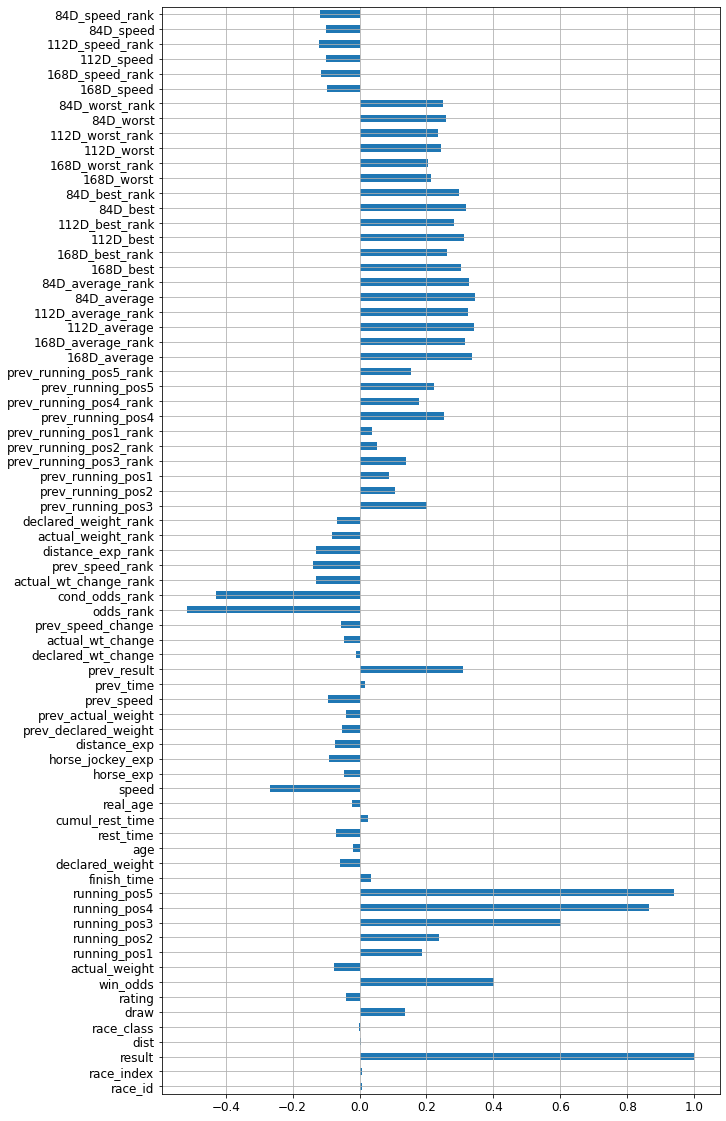

In [80]:
roll_records.corrwith(roll_records["result"]).plot(kind='barh', 
                                                   figsize=(10,20),
                                                   fontsize=12,
                                                   grid = True
                                                  )

In [172]:
roll_records.groupby(["jockey"])["prev_result"].transform(lambda s: s.rolling("168D", min_periods=1).mean())
#roll_records["168D_participation"] = roll_records.groupby(['name', pd.Grouper(freq='168D', key='date')]).count()
records.corrwith(testo)

TypeError: '<' not supported between instances of 'Timestamp' and 'int'

In [164]:
records.groupby(["id"])["declared_weight"].mad()

id
HK_2014_T262    13.766667
HK_2014_T372     8.863893
HK_2014_T380    13.119329
HK_2015_V149    13.495510
HK_2015_V235    14.603263
HK_2015_V303    27.554940
HK_2015_V378    19.837072
HK_2015_V417    16.987245
HK_2016_A005    12.545684
HK_2016_A040    14.299107
HK_2016_A050    45.951121
HK_2016_A071    12.122449
HK_2016_A086    20.219955
HK_2016_A127    13.232600
HK_2016_A164    17.074552
HK_2016_A201    10.834718
HK_2016_A207    15.379124
HK_2016_A217     9.725806
HK_2016_A235    11.831758
HK_2016_A245    12.565936
HK_2016_A247    16.489600
HK_2016_A278    18.904894
HK_2016_A296    13.563138
HK_2016_A299    25.711934
HK_2016_A320    17.239475
HK_2016_A326    12.084000
HK_2016_A327    10.603878
HK_2016_A354    12.918108
HK_2016_A379    12.081633
HK_2017_B001    18.332703
HK_2017_B013    11.334283
HK_2017_B025    15.276800
HK_2017_B027     9.989292
HK_2017_B030    12.085938
HK_2017_B033    14.124082
HK_2017_B085    21.018730
HK_2017_B087    13.095690
HK_2017_B089    17.459320
HK_2017_B

In [157]:
records = records[records.result.notna()]
participants_count = records.groupby(['race_index','date'])['id'].count()
result_sum = records.groupby(['race_index','date'])['result'].sum()

race_checker = (lambda p,r: r == (p / 2)*(1 + p))
race_checker(participants_count, result_sum)

TypeError: incompatible index of inserted column with frame index

In [87]:

def race_checker(p, r):
    
    participants = records.groupby(['race_index','date'])['id'].count()
    result = records.groupby(['race_index','date'])['result'].sum()
    
    for x in p :
        
        if x == 14 and y == 105:
            return True       
        else:
            return False


ValueError: too many values to unpack (expected 2)

In [29]:
records.groupby(['race_index','date'])['result'].sum()

race_index  date      
1.0         2019-09-01      2.0
            2020-09-06     12.0
            2021-09-05     34.0
2.0         2019-09-01     11.0
            2020-09-06     14.0
            2021-09-05     28.0
3.0         2020-09-06     78.0
            2021-09-05     53.0
4.0         2019-09-01     24.0
            2020-09-06     47.0
            2021-09-05     42.0
5.0         2018-09-02      4.0
            2019-09-01     19.0
            2020-09-06     45.0
            2021-09-05     56.0
6.0         2018-09-02      3.0
            2019-09-01     23.0
            2020-09-06     30.0
            2021-09-05     87.0
7.0         2018-09-02      6.0
            2019-09-01      8.0
            2020-09-06     72.0
            2021-09-05     52.0
8.0         2017-09-03      6.0
            2018-09-02     26.0
            2019-09-01     25.0
            2020-09-06     10.0
            2021-09-05     91.0
9.0         2017-09-03      4.0
            2018-09-02     14.0
            2019-